In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 21140.75it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

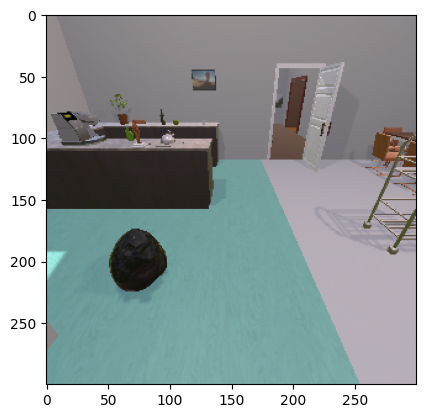

In [3]:
import matplotlib.pyplot as plt
event = controller.step("MoveAhead")
plt.imshow(event.frame)

In [4]:
event.metadata["agent"]["position"]

{'x': 3.5, 'y': 0.9009997844696045, 'z': 5.0}

In [3]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnv, CLIPNovelty, load_actor_critic
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [27]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


In [11]:
from torchinfo import summary

summary(clip_actor_critic.actor), summary(clip_actor_critic.critic), summary(clip_actor_critic.actor_critic_encoder)

(==========================================================================================
 Layer (type:depth-idx)                                            Param #
 SlidingWindowTransformerActor                                     8,192
 ├─TransformerEncoder: 1-1                                         --
 │    └─ModuleList: 2-1                                            --
 │    │    └─TransformerEncoderLayer: 3-1                          789,760
 │    │    └─TransformerEncoderLayer: 3-2                          789,760
 │    │    └─TransformerEncoderLayer: 3-3                          789,760
 │    │    └─TransformerEncoderLayer: 3-4                          789,760
 ├─Linear: 1-2                                                     771
 Total params: 3,168,003
 Trainable params: 3,168,003
 Non-trainable params: 0
 ==========================================================================================,
 Layer (type:depth-idx)                                            Param #
 S

In [31]:
load_actor_critic(clip_actor_critic, "data/Full Run/no_curiosity/no_curiosity_69.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/Full Run/no_curiosity/no_curiosity_69.pt


In [ ]:
from rl import PPO
import torch
from rl import inference_video_mp4, inference

def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


points = {
    "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    # "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    # "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for i in range(4):
    for name, point in points.items():
        inference_video_mp4(get_distributions, init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}_{i}.mp4")

[🎞️] Saved video to rolloutcenter_point.mp4


In [36]:
from models import SmallCNNEncoder

ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = SmallCNNEncoder(FEAT_DIM, device=DEVICE)
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnv(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)

In [37]:
load_actor_critic(clip_actor_critic, "data/Full Run/cnn_scratch/cnn_scratch_69.pt", device=DEVICE)

[🔁] Actor-Critic checkpoint loaded from data/Full Run/cnn_scratch/cnn_scratch_69.pt


In [ ]:
import torch
from rl import inference_video_mp4, inference

def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    # dist = torch.distributions.Categorical(probs=torch.tensor([0.5,0.25,0.25]))
    return dist


points = {
    "center_point": {'x': 3.25, 'y': 0.9009997844696045, 'z': 5.0},
    "trapped": {'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654},
    "inside_room": {'x': 8.765543937683105, 'y': 0.9009993672370911, 'z': 6.941987037658691},
}

for i in range(4):
    for name, point in points.items():
        inference_video_mp4(get_distributions, init_position=point, env=clip_env, actor_critic=clip_actor_critic, video_path=f"rollout{name}_{i}.mp4")

[🎞️] Saved video to rolloutcenter_point_0.mp4


[🎞️] Saved video to rollouttrapped_0.mp4


[🎞️] Saved video to rolloutinside_room_0.mp4


[🎞️] Saved video to rolloutcenter_point_1.mp4


[🎞️] Saved video to rollouttrapped_1.mp4


[🎞️] Saved video to rolloutinside_room_1.mp4


[🎞️] Saved video to rolloutcenter_point_2.mp4


[🎞️] Saved video to rollouttrapped_2.mp4


[🎞️] Saved video to rolloutinside_room_2.mp4


[🎞️] Saved video to rolloutcenter_point_3.mp4


[🎞️] Saved video to rollouttrapped_3.mp4
[🎞️] Saved video to rolloutinside_room_3.mp4


In [259]:
event.metadata["agent"]["position"]

{'x': 5.6405439376831055, 'y': 0.9009993672370911, 'z': 7.591506481170654}

In [11]:
controller.stop()